In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats

filename = 'agent_log_9'

x_max = 400
y_max = 400
z_max = 20

no_of_samples = 16
r = 2
d = 20

In [13]:
df = pd.read_csv("output/" + filename + ".csv")
data = df[df["tick"] == 20]#df["tick"].max()]
data = data.reset_index(drop=True)

In [14]:
def systematic_regular(no_of_samples, x, y):
    # Calculate the dimensions of the regular grid
    rows = int(np.sqrt(no_of_samples))
    cols = int(np.ceil(no_of_samples / rows))

    # Calculate the padding to ensure points are equally spaced
    padding_x = (x - (rows - 1)) // rows
    padding_y = (y - (cols - 1)) // cols

    # Initialize points list
    points = []

    # Select equally spaced points with padding
    for i in range(rows):
        for j in range(cols):
            points.append((int((i * (padding_x + 1)) + ((padding_x + 1)/2)), int((j * (padding_y + 1) + ((padding_y + 1)/2)))))

    return points[:no_of_samples]

def systematic_random(no_of_samples, x, y):
    # Calculate the dimensions of the regular grid
    rows = int(np.sqrt(no_of_samples))
    cols = int(np.ceil(no_of_samples / rows))

    # Calculate the padding to ensure points are equally spaced
    padding_x = (x - (rows - 1)) // rows
    padding_y = (y - (cols - 1)) // cols

    # Initialize points list
    points = []
    x_range = range(int(-(padding_x + 1)/2), int((padding_x + 1)/2))
    y_range = range(int(-(padding_y + 1)/2), int((padding_y + 1)/2))

    # Select equally spaced points with padding
    for i in range(rows):
        for j in range(cols):
            x_offset = np.random.choice(x_range)
            y_offset = np.random.choice(y_range)
            points.append((int((i * (padding_x + 1)) + ((padding_x + 1)/2) + x_offset), int((j * (padding_y + 1) + ((padding_y + 1)/2)) + y_offset)))

    return points[:no_of_samples]

def default_random(no_of_samples, x, y):
    # Initialize points list
    points = []
    x_range = range(x)
    y_range = range(y)

    # Select equally spaced points with padding
    for _ in range(no_of_samples):
        x_coord = np.random.choice(x_range)
        y_coord = np.random.choice(y_range)
        points.append((x_coord, y_coord))

    return points[:no_of_samples]

def wageningen_w():
    return [(50, 50), (50, 150), (50, 250), (50, 350), (150, 150), (150, 250), (250, 150), (250, 250), (350, 50), (350, 150), (350, 250), (350, 350)]
    

In [15]:
def retrieve_ids_per_sample(points, data, r, d):
    samples =  [ [] for _ in range(len(points)) ]
    for ind, row in data.iterrows():
        for index, point in enumerate(points):
            x1, y1 = point
            x2 = row.x
            y2 = row.y
            z2 = row.z

            if (z2 <= d) and ((abs(x1 - x2) + abs(y1 - y2)) <= r):
                samples[index].append(ind)
    return samples   

Selected points: [(7, 65), (67, 115), (58, 251), (26, 339), (156, 33), (164, 174), (110, 218), (129, 367), (219, 48), (292, 190), (298, 289), (299, 384), (391, 23), (393, 135), (376, 260), (317, 329)]
Simulated samples: [[1056, 1248], [88, 527, 559, 611, 1960], [2490, 2826], [2387, 2927, 3095, 3126, 3151, 3353, 3358, 3492, 3507, 3512, 4246, 4255], [1440], [507, 1270, 1418], [2684, 2690, 2865, 2916, 2996, 3025, 3075, 3196, 3316, 3969, 3995, 4220], [], [5515, 5674], [4913, 5252, 5422, 5433, 5477, 6068, 6448, 6496], [7648], [8310, 8474, 8505], [5268], [4486], [6962, 7756, 7895], [6940, 7104]]


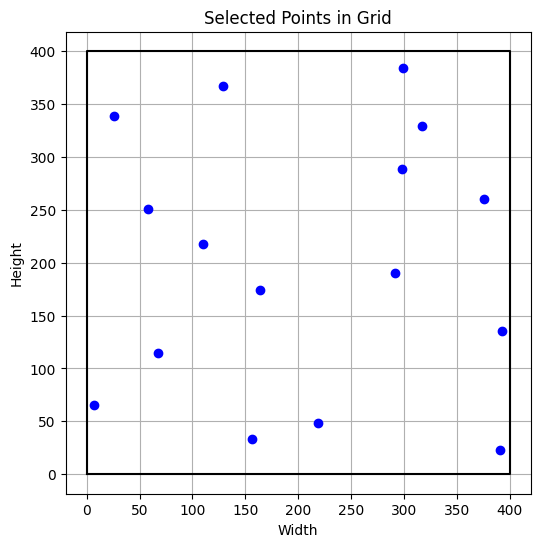

In [16]:
x_max = 400
y_max = 400
z_max = 20

no_of_samples = 16
r = 4
d = 20

#selected_points = systematic_regular(no_of_samples, x_max, y_max)
selected_points = systematic_random(no_of_samples, x_max, y_max)
#selected_points = default_random(no_of_samples, x_max, y_max)
#selected_points = wageningen_w()
samples = retrieve_ids_per_sample(selected_points, data, r, d)

print("Selected points:", selected_points)
print("Simulated samples:", samples)

# Plotting the points in a grid
plt.figure(figsize=(6, 6))
plt.plot([0, x_max, x_max, 0, 0], [0, 0, y_max, y_max, 0], 'k-')  # Plot grid boundaries
for ind, point in enumerate(selected_points):
    plt.plot(point[0], point[1], 'bo')#, markersize=(0.1 * len(samples[ind])))  # Plot selected points
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Selected Points in Grid')
plt.grid(True)
plt.axis('equal')
plt.show()

In [17]:
sample_site_counts = []
for sample_site in samples:
    df2 = data.iloc[sample_site]
    count = df2['type'].value_counts().reindex(range(len(df["type"].unique())), fill_value=0)
    sample_site_counts.append([val for _, val in count.items()])


In [18]:
def pearson_cooccurrence(abundance_data, threshold=0):
    # Initialize a graph
    G = nx.Graph()

    # Calculate the Pearson correlation coefficient matrix
    pearson_matrix = np.corrcoef(abundance_data)

    # Get the number of entities
    num_entities = len(abundance_data[0])

    # Iterate through the Pearson correlation matrix to create co-occurrence edges
    for i in range(num_entities):
        for j in range(i + 1, num_entities):
            # Check if the correlation coefficient exceeds the threshold
            if (not np.isnan(pearson_matrix[i][j])) and (pearson_matrix[i][j] > threshold):
                G.add_edge(i, j, weight=pearson_matrix[i][j])

    return G, pearson_matrix

def spearman_cooccurrence(abundance_data, threshold=0):
    # Initialize a graph
    G = nx.Graph()

    # Calculate the Pearson correlation coefficient matrix
    spearman_matrix = stats.spearmanr(abundance_data).statistic
    
    # Get the number of entities
    num_entities = len(abundance_data[0])

    # Iterate through the Pearson correlation matrix to create co-occurrence edges
    for i in range(num_entities):
        for j in range(i + 1, num_entities):
            # Check if the correlation coefficient exceeds the threshold
            if (not np.isnan(spearman_matrix[i][j])) and (spearman_matrix[i][j] > threshold):
                G.add_edge(i, j, weight=spearman_matrix[i][j])

    return G, spearman_matrix

/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/timovdk/soil_sim/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


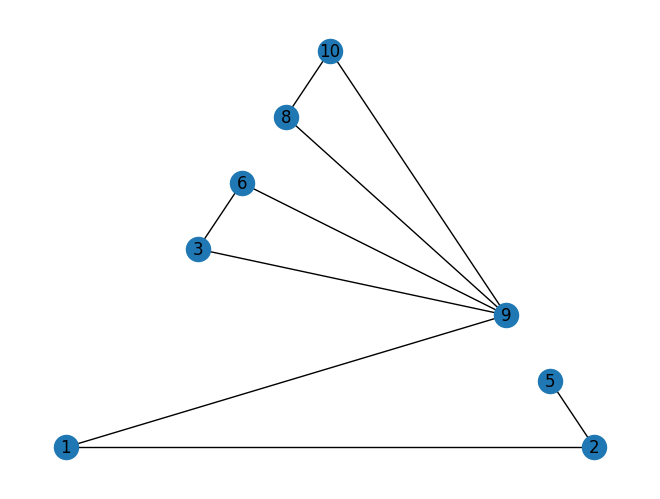

In [19]:
pearson_net, pearson = pearson_cooccurrence(sample_site_counts, 0.3)

nx.draw_planar(pearson_net, with_labels=True)

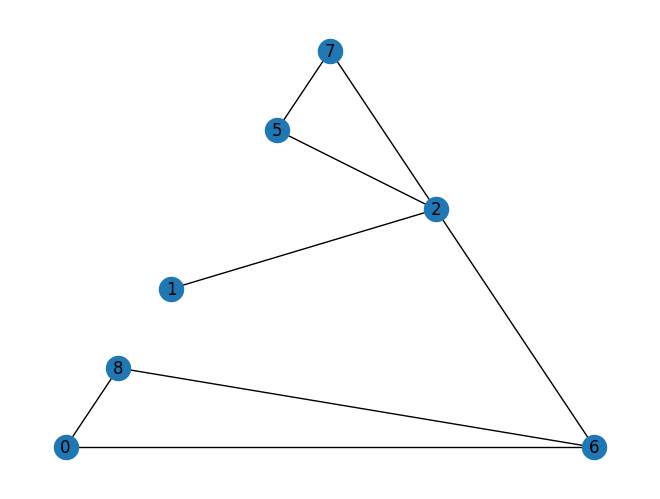

In [20]:
spearman_net, spearman = spearman_cooccurrence(sample_site_counts, 0.3)

nx.draw_planar(spearman_net, with_labels=True)

In [21]:
nx.graph_edit_distance(pearson_net, spearman_net)

4.0

In [22]:
G = nx.Graph()

G.add_nodes_from(
    [
        (0, {"organism": "bacteria"}),
        (1, {"organism": "fungi"}),
        (2, {"organism": "mycorrhizae"}),
        (3, {"organism": "amoebae"}),
        (4, {"organism": "flagellates"}),
        (5, {"organism": "root-feeding nematodes"}),
        (6, {"organism": "bacterivorous nematodes"}),
        (7, {"organism": "fungivorous nematodes"}),
        (8, {"organism": "omnivorous nematodes"}),
        (9, {"organism": "fungivorous mites"}),
        (10, {"organism": "omnivorous mites"}),
        (11, {"organism": "collembolans"}),
    ]
)
G.add_edge(0, 6, weight=-0.5)
G.add_edge(0, 4, weight=-0.5)
G.add_edge(0, 8, weight=-0.5)
G.add_edge(0, 3, weight=-0.5)

G.add_edge(1, 7, weight=-0.5)
G.add_edge(1, 9, weight=-0.5)
G.add_edge(1, 11, weight=-0.5)

G.add_edge(2, 7, weight=-0.5)
G.add_edge(2, 9, weight=-0.5)
G.add_edge(2, 11, weight=-0.5)

G.add_edge(3, 8, weight=-0.5)

G.add_edge(4, 8, weight=-0.5)
G.add_edge(4, 3, weight=-0.5)

G.add_edge(5, 8, weight=-0.5)
G.add_edge(5, 10, weight=-0.5)

G.add_edge(6, 8, weight=-0.5)
G.add_edge(6, 10, weight=-0.5)

G.add_edge(7, 8, weight=-0.5)
G.add_edge(7, 10, weight=-0.5)

G.add_edge(8, 10, weight=-0.5)

G.add_edge(9, 10, weight=-0.5)

G.add_edge(11, 10, weight=-0.5)